## Imports

In [1]:
import sys
import numba
import numpy as np
import pandas as pd
from math import e
from os.path import abspath, join as opj
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from scipy import interpolate as interp
from tqdm.notebook import tqdm
from umap import UMAP

sys.path.insert(0, abspath('../helpers/'))
from participant import Participant
from experiment import Experiment

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

'0.45.1'

## Set paths & params

In [2]:
embeddings_dir = '../../data/embeddings'
models_dir = '../../data/models/'
fig_dir = '../../paper/figs/'

plt.rcParams['pdf.fonttype'] = 42
sns.set_context('paper')
# cmap = 'rocket'

## Define functions

In [3]:
@numba.njit
def correlation_exp(x, y):
    x = e ** x
    y = e ** y
    mu_x = 0.0
    mu_y = 0.0
    norm_x = 0.0
    norm_y = 0.0
    dot_product = 0.0

    for i in range(x.shape[0]):
        mu_x += x[i]
        mu_y += y[i]

    mu_x /= x.shape[0]
    mu_y /= x.shape[0]

    for i in range(x.shape[0]):
        shifted_x = x[i] - mu_x
        shifted_y = y[i] - mu_y
        norm_x += shifted_x ** 2
        norm_y += shifted_y ** 2
        dot_product += shifted_x * shifted_y

    if norm_x == 0.0 and norm_y == 0.0:
        dist = 0.0
        grad = np.zeros(x.shape)
    elif dot_product == 0.0:
        dist = 1.0
        grad = np.zeros(x.shape)
    else:
        dist = 1.0 - (dot_product / np.sqrt(norm_x * norm_y))
        grad = ((x - mu_x) / norm_x - (y - mu_y) / dot_product) * dist

    return dist, grad

## Load data

In [68]:
exp = Experiment()
exp.load_lecture_trajs()
exp.load_question_vectors()
exp.load_participants(load_avg=True)
participants = exp.participants
avg_participant = exp.avg_participant
n_topics = exp.lda_params['n_components']
umap_params = exp.umap_params
seed = umap_params['random_state']
umap_params['metric'] = correlation_exp
# umap_params['n_neighbors'] = 50
umap_params['min_dist'] = .9
# umap_params['n_epochs'] = 1000
print(umap_params)

{'n_components': 2, 'n_neighbors': 15, 'min_dist': 0.9, 'spread': 1.0, 'random_state': 0, 'metric': CPUDispatcher(<function correlation_exp at 0x7fd9629bf050>)}


In [93]:
import sklearn
print(sklearn.__version__)

0.21.3


## Create 2D embeddings

In [69]:
# concatenate all data along fetaure dimension to embed in a shared space
to_reduce = exp.get_lecture_traj(['forces', 'bos'])
to_reduce.extend(list(exp.get_question_vecs(lectures=['forces', 'bos', 'general'])))
# store data incidces to separate embedded matrix later
split_inds = np.cumsum([np.atleast_2d(vec).shape[0] for vec in to_reduce])[:2]
# log-transform 
to_reduce = np.log(np.vstack(to_reduce))

In [70]:
np.random.seed(seed)
reducer = UMAP(verbose=True, **umap_params).fit(to_reduce)
embeddings = reducer.embedding_
forces_emb, bos_emb, questions_embs = np.vsplit(embeddings, split_inds)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False,
     metric=CPUDispatcher(<function correlation_exp at 0x7fd9629bf050>),
     metric_kwds=None, min_dist=0.9, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Mar 10 17:29:21 2020 Finding Nearest Neighbors
Tue Mar 10 17:29:21 2020 Finished Nearest Neighbor Search
Tue Mar 10 17:29:21 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  50

In [71]:
# save fit UMAP reducer and 2D embeddings
# np.save(opj(models_dir, 'UMAP_reducer'), reducer)
# np.save(opj(embeddings_dir, 'forces_lecture'), forces_emb)
# np.save(opj(embeddings_dir, 'bos_lecture'), bos_emb)
# np.save(opj(embeddings_dir, 'questions'), questions_embs)
# exp.load_reducer()
# exp.load_embeddings()

## Create a 2D grid

In [72]:
resolution = 50
x_min, y_min = embeddings.min(axis=0) // 1
x_max, y_max = embeddings.max(axis=0) // 1 + 1
x_step = (x_max - x_min) / resolution
y_step = (y_max - y_min) / resolution
xs = np.arange(x_min, x_max, x_step)
ys = np.arange(y_min, y_max, y_step)

X, Y = np.meshgrid(xs, ys)
xy_grid = np.empty((resolution, resolution, 2), dtype=np.float64)
for (x_ix, y_ix), X_val in np.ndenumerate(X):
    xy_grid[x_ix, y_ix] = (X_val, Y[x_ix, y_ix])

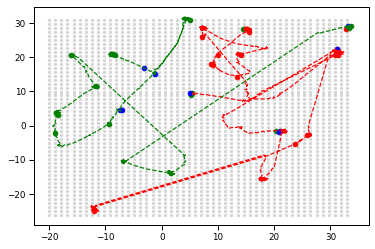

In [73]:
vertices = xy_grid.reshape(resolution**2, 2)

plt.scatter(vertices[:, 0], vertices[:, 1], c='lightgrey', marker='.')
plt.plot(forces_emb[:, 0], forces_emb[:, 1], 'r--')
plt.plot(bos_emb[:, 0], bos_emb[:, 1], 'g--')
plt.scatter(questions_embs[:15, 0], questions_embs[:15, 1], c='r', marker='o')
plt.scatter(questions_embs[15:30, 0], questions_embs[15:30, 1], c='g', marker='o')
plt.scatter(questions_embs[30:, 0], questions_embs[30:, 1], c='b', marker='o')

In [ ]:
def interp_inv_transform(xy_coords, topic_props):
    """
    given a (n_xcoords, n_ycoords, xy_coords) grid of coordinates
    and a (n_xcoords, n_ycoords, ndims) grid of topic vectors,
    interpolate topic proportions at xy_coords where UMAP inverse
    transform failed (i.e., returned a topic vector of all zeros)
    """
    err_mask = np.all(np.equal(topic_props, 0), axis=2)
    good_coords = xy_coords[~err_mask]
    err_coords = xy_coords[err_mask]
    good_vectors = topic_props[~err_mask]
    interpolator = LinearNDInterpolator(good_coords, good_vectors)
    fixed_vals = interpolator(err_coords)
    topic_props[err_mask] = fixed_vals
    return topic_props

In [16]:
flat_grid = xy_grid.reshape(2500, 2)

In [19]:
interp.griddata(embeddings, to_reduce, flat_grid, 'cubic')

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [78]:
rbf = interp.Rbf(embeddings[:, 0], embeddings[:, 1], to_reduce, mode='N-D')

In [79]:
rbf_grid = rbf(X, Y)

In [88]:
topic_space_vertices = rbf_grid.reshape(resolution**2, n_topics)
topic_space_vertices = np.exp(topic_space_vertices)
topic_space_vertices /= topic_space_vertices.sum(axis=1, keepdims=True)
topic_space_grid = topic_space_vertices.reshape(resolution, resolution, n_topics)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [91]:
topic_space_grid

array([[[2.41491167e-213, 4.15164064e-158, 2.61516807e-064, ...,
         0.00000000e+000, 2.87377394e-232, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        ...,
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000]],

       [[2.79241331e-138, 1.48498353e-090, 7.44704254e-004, ...,
         0.00000000e+000, 1.36847423e-158, 0.00000000e+000],
        [2.32323907e-161, 5.96234400e-123, 2.96320787e-054, ...,
         0.00000000e+000, 4.69670516e-

In [84]:
# plt.pcolor(X, Y, rbf_grid, cmap=plt.cm.jet)
# # plt.scatter(embeddings[:, 0], embeddings[:, 1], 100, z, cmap=cm.jet)

## Recover a topic vector for each grid point

In [51]:
# inverse-transform grid into original topic space
np.random.seed(reducer.transform_seed)
topic_space_vertices = reducer.inverse_transform(vertices).astype(np.float64)
# undo log-transform & normalize
topic_space_vertices = np.exp(topic_space_vertices)
topic_space_vertices /= topic_space_vertices.sum(axis=1, keepdims=True)
# reshape to grid
topic_space_grid = topic_space_vertices.reshape(resolution, resolution, n_topics)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


## Reconstruct memory traces for every grid point

In [481]:
# # maps constructed by "reconstructing trace" from topic vector at each grid point
# maps_arr = np.empty((3, exp.n_participants, resolution, resolution), dtype=np.float64)
# for qset in range(3):
#     store_key = f'kmap_qset{qset}'
#     for i, p in enumerate(tqdm(participants, desc=f'{qset+1}/3', leave=False)):
#         knowledge_map = p.reconstruct_trace(exp, 
#                                             content=topic_space_vertices, 
#                                             qset=qset).reshape(resolution, resolution)
#         p.store_trace(knowledge_map, store_key)
#         maps_arr[qset, i] = knowledge_map
#     # store average in avg participant 
#     avg_participant.store_trace(maps_arr[qset].mean(axis=0), store_key)

# exp.participants = participants
# exp.avg_participant = avg_participant

In [52]:
# maps constructed using topic vector correlation-weighted proportion correct
maps_arr = np.empty((3, exp.n_participants, resolution, resolution), dtype=np.float64)
for qset in range(3):
    store_key = f'kmap_qset{qset}'
    for i, p in enumerate(tqdm(participants, desc=f'{qset+1}/3', leave=False)):
        p_qset_data = p.get_data(qset=range(qset + 1))
        acc = p_qset_data['accuracy'].astype(bool)
        qids = p_qset_data['qID'].tolist()
        question_vecs = exp.get_question_vecs(qids=qids)
        question_corrs = 1 - cdist(topic_space_vertices, question_vecs, metric='correlation')
        # locations about which questions provide no information should be 0
        question_corrs[question_corrs < 0] = 0
        all_sum = question_corrs.sum(axis=1)
        # set minimal value to avoid ZeroDivisionErrors
        all_sum[all_sum <= 0] = 1e-11
        correct_sum = question_corrs[:, acc].sum(axis=1)
        knowledge_map = (correct_sum / all_sum).reshape(resolution, resolution)
        p.store_trace(knowledge_map, store_key)
        maps_arr[qset, i] = knowledge_map
    # store average in avg participant 
    avg_participant.store_trace(maps_arr[qset].mean(axis=0), store_key)
exp.participants = participants
exp.avg_participant = avg_participant

In [53]:
# uniformly shift coordinates to line up with heatmap for plotting
embeddings_plotscaled = embeddings - embeddings.min(axis=0)
embeddings_plotscaled /= (embeddings_plotscaled.max(axis=0) / resolution)
forces_plotscaled, bos_plotscaled, questions_plotscaled = np.vsplit(embeddings_plotscaled, split_inds)
ff_qs_plotscaled = questions_plotscaled[:15]
bos_qs_plotscaled = questions_plotscaled[15:30]
gen_qs_plotscaled = questions_plotscaled[30:]

0.0 0.6
0.0 0.8
0.0 0.9


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


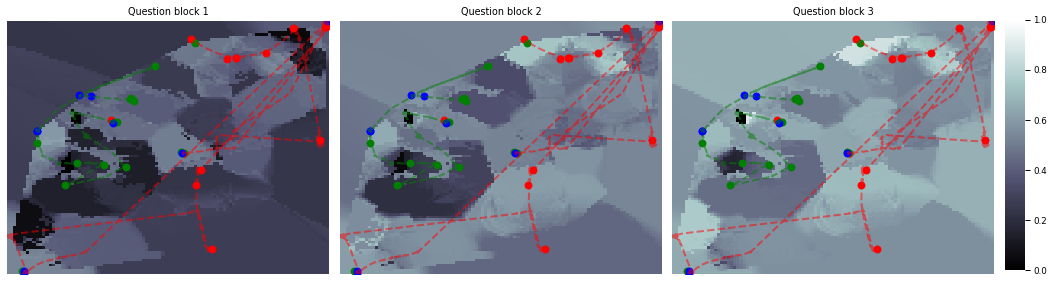

In [54]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(14, 4)
cbar_ax = fig.add_axes([1, 0.05, .02, .87])
for i in range(3):
    kmap = avg_participant.traces[f'kmap_qset{i}']
    low, high = kmap.min().round(1), kmap.max().round(1)
    print(low, high)
    cbar = True if i == 2 else False
    cax = cbar_ax if i == 2 else None
    sns.heatmap(kmap, vmin=0, vmax=1, cmap='bone', xticklabels=[], yticklabels=[], 
                cbar=cbar, ax=axes[i], cbar_ax=cax)
    axes[i].plot(forces_plotscaled[:, 0], forces_plotscaled[:, 1], 'r--', alpha=.5, linewidth=2)
    axes[i].plot(bos_plotscaled[:, 0], bos_plotscaled[:, 1], 'g--', alpha=.5, linewidth=2)
#     axes[i].scatter(questions_plotscaled[:, 0], questions_plotscaled[:, 1], c='b', marker='o', s=50)
    axes[i].scatter(ff_qs_plotscaled[:, 0], ff_qs_plotscaled[:, 1], c='r', marker='o', s=50)
    axes[i].scatter(bos_qs_plotscaled[:, 0], bos_qs_plotscaled[:, 1], c='g', marker='o', s=50)
    axes[i].scatter(gen_qs_plotscaled[:, 0], gen_qs_plotscaled[:, 1], c='b', marker='o', s=50)
    axes[i].set_title(f'Question block {i + 1}')
plt.tight_layout()
plt.show()

-0.1478231501257362 0.5
-0.10293071968966794 0.36


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


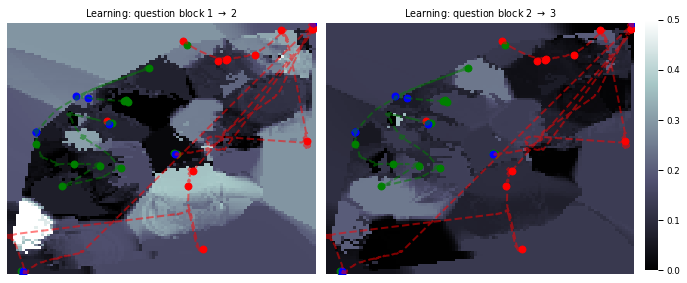

In [55]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(9, 4)
cbar_ax = fig.add_axes([1, 0.05, .02, .87])
for i in range(2):
    learning_map = avg_participant.traces[f'kmap_qset{i + 1}'] - avg_participant.traces[f'kmap_qset{i}']
    print(learning_map.min(), learning_map.max())
    cbar = True if i == 1 else False
    cax = cbar_ax if i == 1 else None
    sns.heatmap(learning_map, vmin=0, vmax=.5, cmap='bone', xticklabels=[], yticklabels=[],
               cbar=cbar, ax=axes[i], cbar_ax=cbar_ax)
    axes[i].plot(forces_plotscaled[:, 0], forces_plotscaled[:, 1], 'r--', alpha=.5, linewidth=2)
    axes[i].plot(bos_plotscaled[:, 0], bos_plotscaled[:, 1], 'g--', alpha=.5, linewidth=2)
#     axes[i].scatter(questions_plotscaled[:, 0], questions_plotscaled[:, 1], c='b', marker='o', s=50)
    axes[i].scatter(ff_qs_plotscaled[:, 0], ff_qs_plotscaled[:, 1], c='r', marker='o', s=50)
    axes[i].scatter(bos_qs_plotscaled[:, 0], bos_qs_plotscaled[:, 1], c='g', marker='o', s=50)
    axes[i].scatter(gen_qs_plotscaled[:, 0], gen_qs_plotscaled[:, 1], c='b', marker='o', s=50)
    axes[i].set_title(r'Learning: question block {} $\rightarrow$ {}'.format((i + 1), (i + 2)))
plt.tight_layout()
plt.show()

# Sanity check - single map for single participant/question

In [20]:
topic_space_grid[0,0]

array([0.00660867, 0.00660867, 0.00660867, 0.00660867, 0.0927201 ,
       0.00660867, 0.00660867, 0.00660867, 0.70648143, 0.00660867,
       0.00660867, 0.00660867, 0.00660867, 0.00660867, 0.05540775,
       0.00660867, 0.00660867, 0.00660867, 0.00660867, 0.00660867,
       0.00660867, 0.00660867, 0.00660867, 0.00660867, 0.00660867])

In [21]:
topic_space_grid[0,1]

array([0.00657879, 0.00657879, 0.00657879, 0.00657879, 0.09279763,
       0.00657879, 0.00657879, 0.00657879, 0.70766647, 0.00657879,
       0.00657879, 0.00657879, 0.00657879, 0.00657879, 0.05480253,
       0.00657879, 0.00657879, 0.00657879, 0.00657879, 0.00657879,
       0.00657879, 0.00657879, 0.00657879, 0.00657879, 0.00657879])